In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install missingno # my favorite NaN visualizer
import missingno as msno


# Some copy-pasta options to improve print quality
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


In [3]:
# Designate data types for imports
data_types = {'Category': 'category', 'Qty': 'float64', 'Price Point Name': 'category', 'Event Type': 'category'}
files = ["items_2013_raw.csv", "items_2014_raw.csv", "items_2015_raw.csv", 
         "items_2016_raw.csv", "items_2017_raw.csv", "items_2018_raw.csv", 
         "items_2019_raw.csv", "items_2020_raw.csv", "items_2021_raw.csv"] 
df = pd.DataFrame()

# create a dataset containing all transactions from the last 9 years
for file in files:
    path = '/Users/mymac/Desktop/Comet_Data/Items/'+file
    # import csv
    if df.empty == False:
        df_raw = pd.read_csv(path, parse_dates=[['Date', 'Time']], thousands=',', dtype=data_types)

        # convert dollar strings to workable floats
        dollar_cols =["Gross Sales", "Discounts", "Net Sales", "Tax"]
        df_raw[dollar_cols] = df_raw[dollar_cols].replace('[\$,]', '', regex=True).astype(float)

        # only a couple odd fractional values in qty, we'll make it an integer column
        df_raw["Qty"] = df_raw["Qty"].round().astype('int64')

        # a few columns without immediately useful information we can remove
        df_raw.drop(labels=["SKU", "Device Name", "Dining Option", 
                        "Time Zone", "Unit", "Notes", 
                        "Price Point Name", "Details", "Count", 
                        "Payment ID", "Customer ID"], axis=1, inplace=True)
        df = pd.concat([df, df_raw], ignore_index=True)
        
    # create the DataFrame
    else: 
        df = pd.read_csv(path, parse_dates=[['Date', 'Time']], thousands=',', dtype = data_types)
        dollar_cols =["Gross Sales", "Discounts", "Net Sales", "Tax"]
        df[dollar_cols] = df[dollar_cols].replace('[\$,]', '', regex=True).astype(float)
        df["Qty"] = df["Qty"].round().astype('int64')
        df.drop(labels=["SKU", "Device Name", "Dining Option", 
                        "Time Zone", "Unit", "Notes", 
                        "Price Point Name", "Details", "Count", 
                        "Payment ID", "Customer ID"], axis=1, inplace=True)

# Write a complete dataset to your desktop
df.to_csv('/Users/mymac/Desktop/all_items.csv')      

In [5]:
# Update our new file's value types to reduce its size.
data_types = {'Category': 'category', 'Qty': 'int64', 'Price Point Name': 'category', 
              'Event Type': 'category', 'Location': 'category'}
df = pd.read_csv('/Users/mymac/Desktop/all_items.csv', parse_dates=['Date_Time'], dtype=data_types)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043844 entries, 0 to 1043843
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1043844 non-null  int64         
 1   Date_Time              1043844 non-null  datetime64[ns]
 2   Category               1043844 non-null  category      
 3   Item                   1043844 non-null  object        
 4   Qty                    1043844 non-null  int64         
 5   Modifiers Applied      524772 non-null   object        
 6   Gross Sales            1043844 non-null  float64       
 7   Discounts              1043844 non-null  float64       
 8   Net Sales              1043844 non-null  float64       
 9   Tax                    1043844 non-null  float64       
 10  Transaction ID         1043844 non-null  object        
 11  Event Type             1043844 non-null  category      
 12  Location               10438

In [6]:
# Remove added index column
df.drop("Unnamed: 0", axis=1, inplace=True)

# And sort df by Date_Time
df.sort_values(by="Date_Time", inplace=True)

<AxesSubplot:>

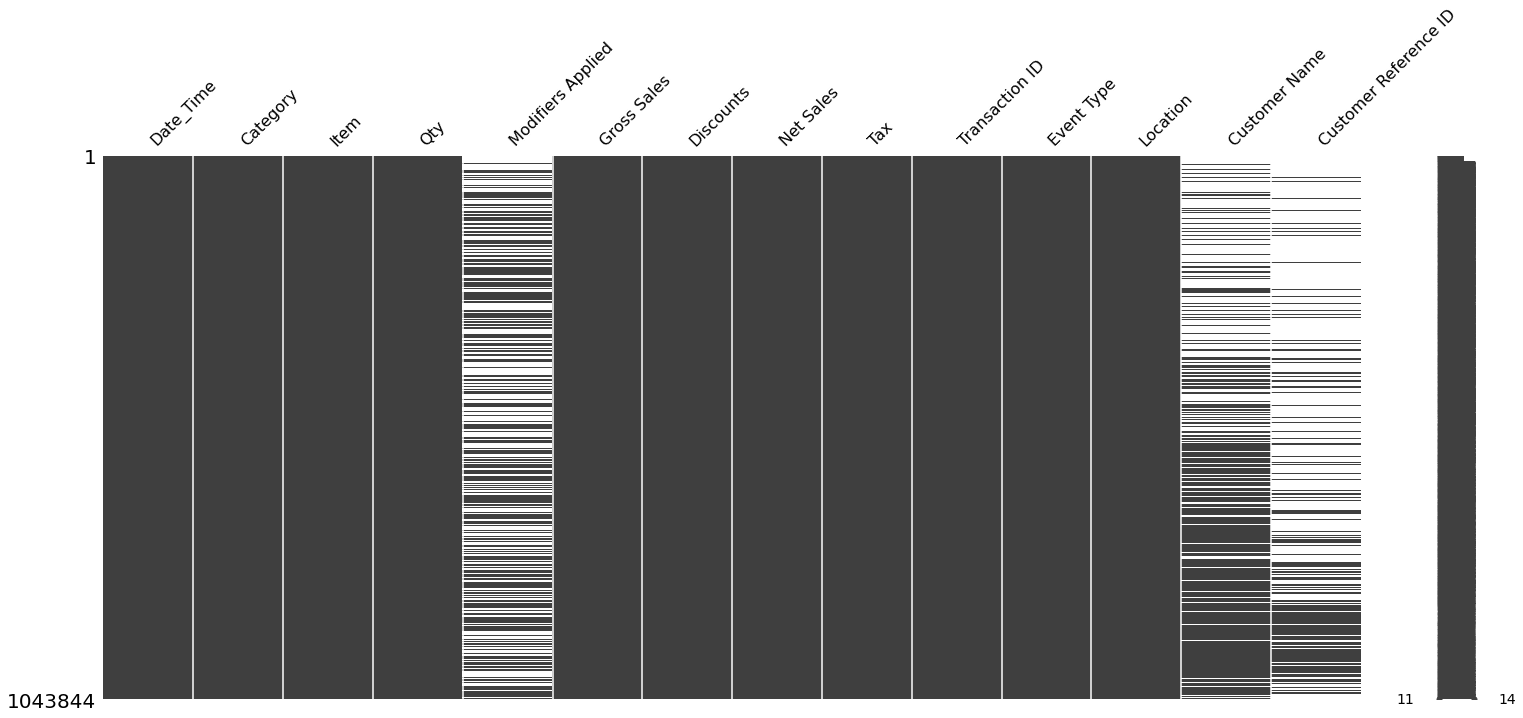

In [7]:
# Examine the completeness of our new dataset

msno.matrix(df)

# The interesting field here is "Customer Name"; the name is only taken when a card is used.
# Note how the frequency increases over time. During the pandemic we transitioned to online-only
# transactions; so a significant portion of the customer data during that period is complete.

Category
Coffee      609709
Bakery      455098
Retail       44343
None         22979
Kitchen      21632
Creamery     17402
Payment        218
Name: Qty, dtype: int64


<AxesSubplot:xlabel='Category'>

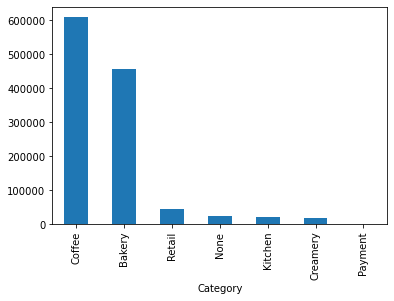

In [8]:
# A List of Item Types and their sales frequency
cats = df.groupby("Category").Qty.sum().sort_values(ascending=False)
print(cats)
cats.plot(kind='bar')

<function matplotlib.pyplot.show(close=None, block=None)>

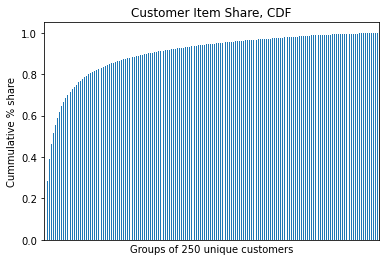

In [9]:
# A quick look at how important the retention of regulars is. For future analysis, a metric for customer churn
# would be a useful tool.
x = df.groupby("Customer Name").sum().sort_values(by="Qty",ascending=False)

values = []
values_i = []
bin_w = 250
d = 0
g = 0
for s in range(int(x["Net Sales"].count()/bin_w)+1):
    value = x.iloc[bin_w*(s-1):bin_w*s, 3].sum()/x.iloc[:, 3].sum()
    delta = abs(d+value)
    values.append(delta)
    d = delta

for s in range(int(x["Net Sales"].count()/bin_w)+1):
    value = x.iloc[bin_w*(s-1):bin_w*s, 3].sum()/x.iloc[:, 3].sum()
    delta = abs(value)
    values_i.append(delta)
    
d = pd.Series(values)
g = pd.Series(values_i)
d.plot(kind='bar')
plt.title('Customer Item Share, CDF')
plt.xlabel(f"Groups of {bin_w} unique customers")
plt.xticks([])
plt.ylabel("Cummulative % share")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

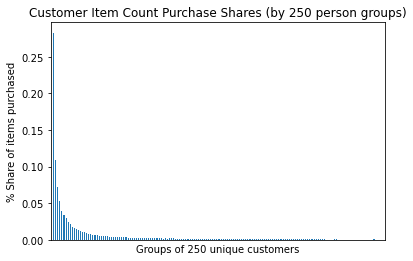

In [10]:
g.plot(kind='bar')
plt.title(f'Customer Item Count Purchase Shares (by {bin_w} person groups)')
plt.xlabel(f"Groups of {bin_w} unique customers")
plt.xticks([])
plt.ylabel("% Share of items purchased")
plt.show

In [11]:
# Creating a new item column to use for analysis w/ generalized item names.
df["Item2"] = df["Item"]

In [12]:
# There are too many items in each category to do meaningful analysis. We'll go granular and get them bundled.
df.groupby("Category").Item2.nunique()

Category
Bakery      370
Coffee      154
None        286
Retail      326
Payment       4
Creamery     49
Kitchen     272
Name: Item2, dtype: int64

In [13]:
# temp = pd.Series(df[df.Category=='Kitchen'].Item.unique())
# temp2 = sorted(temp)
# sum(['Quiche' in s for s in temp2])

# A few quick changes for some of our items. We're going to get a few varieties lumped as single item names.
item_updates = {
'uiche': 'Quiche', 
 'Potato Leek Gruyere': 'Quiche', 
 'Gateau': 'Cake', 
 'cake': 'Cake', 
 'Cake': 'Cake', 
 'Whoopie Pie': 'Whoopie', 
 'Pie': 'Pie', 
 'pie': 'Pie', 
 'Breakfast Sandwich': 'Breakfast Sandwich', 
 'Brioche': 'Sweet_brioche', 
 'heesecake': 'Cheesecake', 
 'Korean Noodles: Gochujang Hobak Jjigae': 'Korean_noodles',
 'Shortbread Bar': 'Shortbread_bar',
 'hortbread': 'Shortbread', 
 'Tax-exempt pain au chocolat': 'Pain au Chocolat', 
 'Gluten Free Buckwheat Chocolate Chip Muffin': 'GF Buckwheat Muffin', 
 'Gluten Free Buckwheat Chocolate Chip muffin': 'GF Buckwheat Muffin', 
 '\\*NEW\\* Gluten Free Chocolate Chip Cookies': 'GF Chocolate Chip Cookie',
 'Gluten Free Buckwheat Chocolate Chip Cookie': 'GF Chocolate Chip Cookie',
    'Sweet Bloom': 'Whole Bean',
    'bean': 'Whole Bean',
    'Bean': 'Whole Bean'
    

}

def replace_col(find, replace_with, dataframe, column):
    ''' Takes a string(find), looks for it in a specified column(dataframe[column]), 
        and then replaces all occurrences with a specified substring(replace_with).
        
        find: string value, required
        replace_with: string value, required
        dataframe: name of dataframe object, required
        column: string or integer value, name of column to search, required'''
    mask = dataframe[column].str.contains(find)
    dataframe.loc[mask, column]=replace_with

for key, value in item_updates.items():
    replace_col(key, value, df, 'Item2')

# for key, value in item_updates.items():
#     temp_mask = df.Item2.str.contains(key)
#     df.loc[temp_mask, "Item2"]=value


In [14]:
# We're interested in Flavored Latte sales. Some of them are classified as 'Latte' with modifiers, 
# some are classified as 'Flavored Latte'. Let's get them all under 'Flavored Latte'

# fill NaN values so Boolean subsetting will work below
df["Modifiers Applied"] = df["Modifiers Applied"].fillna("None")

# Compile a list of all the latte flavors from the Mod column (check df["Modifiers Applied"].value_counts())
flavored_latte = ['Seasonal Pumpkin', 'Vanilla', 'Caramel', 'Dark Chocolate', 
                  'Spring Lavender & Honey', 'Pumpkin']

# loop through the flavors
for flavor in flavored_latte:
    # create a subset Boolean series
    m = df.loc[df["Item2"] == "Latte", "Modifiers Applied"].str.contains(flavor)
    # Subset df to only include Latte rows, subset THAT with m and change Latte to Flavored Latte
    df.update(df.loc[df["Item2"] == "Latte", :].loc[m, "Item2"].replace(to_replace = 'Latte', value='Flavored Latte'))
    
    

In [15]:
# 3 Items we sell a good bit of are hand brewed coffees, espresso, and bags of whole bean.
# Unfortunately, they are under many different names and to do any analysis on them we need
# to get them relabeled into broader items: 'Hand Brewed Coffee', 'Espresso', 'Whole Bean'

espresso_alias = ['Tandem Kenya Kiboi', 'Brandywine Ethiopia Wude Makiso - natural', 
                  'Ethiopia Wachu', 'Ethiopia Wude Makino', 'Ceremony Peru Suyo', 
                  'Sump Zambia, Keteshi', 'Double Espresso', 
                  'Doppio Espresso', 'Blueprint Shot', 'Brick House - Kaldis', 
                  '17ft Ceiling', 'Epic Espresso', 'Creamery Espresso', 'Square Mile']

brew_alias = ['Brick House Brew', 'Coffee', 'Colombia Timana', 'Ethiopia Wachu', 
              'Brandywine Ethiopia Wude Makiso - natural', 'Tandem Kenya Kiboi', 
              'Sump Wolichu Wachu', 'Blueprint Colombia Finca Tamana', 
              'Brandywine Colombia San Pascual - Natural', 'Brandy Wine Ethiopia Wude Makiso', 
              'Brandywine Ethiopia Lemma Mamo', 'Ethiopia Wude Makino', 
              'Brandy Wine Ethiopia Lemma Mamo', 'Sump Zambia, Keteshi', 'Ceremony Peru Suyo', 
              'Brandywine Kenya Boma Peaberry', 'Bb Ethiopia ']


df.update(df.loc[df["Category"]=="Coffee", "Item2"].replace(to_replace=espresso_alias, value='Espresso'))
df.update(df.loc[df["Category"]=="Coffee", "Item2"].replace(to_replace=brew_alias, value='Hand Brewed Coffee'))  

In [16]:
whole_bean = ['Mexico','Blue Bottle', 'Costa Rica', 'Verve', 'Intelligentsia', 
              'Square Mile', 'Kuma - retail', "PT's", 'Blueprint', 'Detour', 
              'Colombia', 'Sump', '49th', 'Ecuador', 'Halfwit', "PT's Coffee", 
              'Bolivia',  '49th Parallel', 'Rwanda', 'Olympia Retail', 'Penrose Retail', 
              'Bbb', 'Tandem Ethiopia', 'Teshome Gemechu', 'Colombia - Finca Timana AAA', 
              'Sump Kenya Gachatha AB','Brandywine Kenya Kapluso AB', 
              'Brandywine Roasters Colombia', 'Rodrigo Sanchez El Progreso, Washed Process', 
              'Brandywine Honduras - Santa Barbara', 'Brandywine Ethiopia Wude Makiso - natural', 
              'PM Columbia Sweet & Flowers', 'PM Geisha tin', 
              'Proud Mary Costa Rica Finca La Angelina (Red Honey)', 
              'Brandywine Costa Rica  - Las Lajas - Black Honey', 'Proud Mary Honduras Chicos Buenos', 
              'Blueprint Gamatui Community', 'Brandywine Costa Rica  - Las Lajas - Perla Negra Natural', 
              'Proud Mary Deluxe 100g tin', 'Tandem Ethiopia, Teshome Gemechu', 
              'Brandywine Roasters Colombia, Rodrigo Sanchez El Progreso, Washed Process', 
              'Blueprint-retail', 'Honduras', 'Sump Kenya', 'Sump AB Kenya', 'Sump Natural Kenya', 
              'Kaldi\'s', 'Intelli Decaf', '49th Para', 'Half Wit', 'Intelli Nicaragua', 
              'Intellihentsia', 'Hama', 'Quills Mexico', 'Kenya', 'Kagumoini', 'Ritual - Hunapu', 
              'Sump Konga', 'Terroir', 'Sump-Abaya', 'Roseline', 'Ritual - Columbia', 'Intelli Colombia', 
              'Quills', 'Blue-mex', 'Ritual']

df.update(df.loc[df["Category"]=="Retail", "Item2"].replace(to_replace=whole_bean, value='Whole Bean'))

In [17]:
# Verify that we didn't miss any whole bean varieties
df[df.Category=="Retail"].Item2.value_counts()

Whole Bean                                                        24851
Bottled Beverage                                                   6234
Brainy Oats                                                        1020
$5 Gift Card                                                        984
Dandelion Chocolate                                                 771
Tea Retail                                                          409
Herbal Teas                                                         362
Hand Packed Pint                                                    336
ComKom Kombucha                                                     184
Rolling Lawns Whole Milk, 1/2 Gallon                                180
Dick Taylor Chocolate                                               162
Loose Leaf Tea Retail, 1oz                                          145
Eclipse Glasses                                                     129
Hario Filters, 100ct                                            

In [18]:
df["Transaction ID"].count()

1043844

In [19]:
# How many items per order on average?
round(df["Qty"].sum()/df["Transaction ID"].nunique(),2)

2.2

In [49]:
# Some test code used for formulating the following function
# ID_list = df["Transaction ID"].unique().tolist()

# ID_Bool = df["Transaction ID"].isin(ID_list)

# df_sub = df.loc[ID_Bool, "Item"]

# df_sub2 = df_sub[df_sub != "Quiche"]


# total = df_sub2.groupby(df_sub2).count().sum()
# df_sub2.groupby(df_sub2).count().sort_values(ascending=False).index[:5].tolist()
# df_sub2.groupby(df_sub2).count().sort_values(ascending=False)[:5]
#print(total)

In [20]:
def pairing(yummy):
    '''Takes the string value of an element of the Item2 category and produces a bar plot of the 
       10 most common items purchased with the element.'''
    if yummy in df.Item2.unique():
        ID_list = df.loc[df.Item2 == yummy, "Transaction ID"]
        ID_list = ID_list.unique()
        ID_Bool = df["Transaction ID"].isin(ID_list)
        df_sub = df.loc[ID_Bool, "Item2"]
        df_sub2 = df_sub[df_sub != yummy]
        # total = df_sub2.groupby(df_sub2).count().sum()
        total_tickets = len(ID_list)
        dat = ((df_sub2.groupby(df_sub2).count().sort_values(ascending=False)[:10]/total_tickets)*100).round(1)
        g = sns.barplot(x=dat.index, y=dat.values)
        g.set(xlabel = "Yummy", ylabel = "%", title=f"% of time item accompanies {yummy}" )
        plt.xticks(rotation=90)
        plt.show()
    else:
        return "Item not found"
    

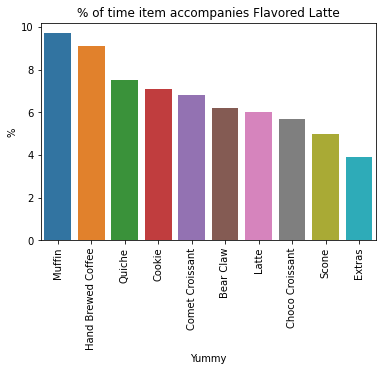

In [22]:
pairing(yummy="Flavored Latte")


Now let's turn our attention to sales volume by hour. During the mid-2020 period of the pandemic I made a decision to reduce our operating hours from 7am-5pm to 7am-2pm. Note that in addition to the hours of operation, 1-2 hours is required in the morning to setup and roughly 30 minutes is required to close down. This presents us with a scheduling window of roughly 12 hours -- not ideal for filling with full-time employees (8-9 hour shifts) that, of course, prefer regularity of hours. Reducing this hours-of-operation window to 7 hours made for a neat 8-9 hour work day for all full time employees. Additionally, the marginal product of labor was greatly increased as a result of dropping the much less productive 2-5pm slump, shown below.

In [24]:
# create some quick date time sub-value columns for ease of analysis
df["Year"] = df.Date_Time.dt.year
df["Month"] = df.Date_Time.dt.month.astype('category')
df["Day"] = df.Date_Time.dt.dayofweek.astype('category')
df["Hour"] = df.Date_Time.dt.hour.astype('category')

In [25]:
# transform to ordered categories so analysis functions properly

months = list(range(1,13))
days = list(range(7))
hours = list(range(24))

df["Month"] = pd.Categorical(df.Month, categories = months, ordered = True)
df["Day"] = pd.Categorical(df.Day, categories = days, ordered = True)
df["Hour"] = pd.Categorical(df.Hour, categories = hours, ordered = True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043844 entries, 59030 to 937051
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Date_Time              1043844 non-null  datetime64[ns]
 1   Category               1043844 non-null  category      
 2   Item                   1043844 non-null  object        
 3   Qty                    1043844 non-null  int64         
 4   Modifiers Applied      1043844 non-null  object        
 5   Gross Sales            1043844 non-null  float64       
 6   Discounts              1043844 non-null  float64       
 7   Net Sales              1043844 non-null  float64       
 8   Tax                    1043844 non-null  float64       
 9   Transaction ID         1043844 non-null  object        
 10  Event Type             1043844 non-null  category      
 11  Location               1043844 non-null  category      
 12  Customer Name          60

In [27]:
all_revenue = df["Gross Sales"].sum()

query = df[["Hour", "Gross Sales"]].groupby("Hour").sum()*100/all_revenue


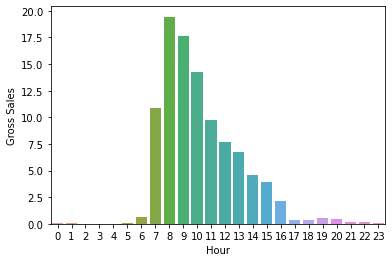

In [28]:
g = sns.barplot(x=query.index, y="Gross Sales", data=query)